# 🧠 SVM-Based VLSI Partitioning Model

This notebook implements a Support Vector Machine (SVM)-based approach for partitioning VLSI netlists represented as graphs.

### Model Logic:
- Each node in the graph represents a circuit component with features:
  - Power, Area, Average Edge Distance, Degree
- Pseudo-labels for supervised learning are generated using **KMeans** clustering.
- An **SVM classifier** is trained on the node features and labels.
- After training, each node is assigned to a partition, and standard partitioning metrics are computed.

### Goals:
- Minimize inter-partition **cut edges**
- Minimize total **wire length**
- Balance **power and area** across partitions
- Reduce **critical path delay**


In [9]:
# SVM Partitioning Model
# Uses pseudo-labels from KMeans and trains an SVM classifier on node features
# Features used: [power, area, avg_edge_distance, degree]

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import random
import math


In [10]:
# Graph Gen 1.2
# Added inputs and outputs
# The power consumption for a node ranges from 1 to 50 units and uniformly distributed.
# Plus the area may vary from 1 to 5 units as well, uniformly distributed
# Ensured the following:
# The input nodes must have at least one outgoing edge and no incoming edge
# The output nodes must have one incoming edge only
# Internal nodes must have at least one incoming and at least one outgoing edge

def generate_netlist(
    num_nodes=50,
    num_edges=100,
    enable_area=True,
    enable_power=True,
    enable_wire_count=True,
    enable_distance=True,
    seed=42
):
    G = nx.DiGraph()
    num_inputs = math.ceil(math.log2(num_nodes))
    num_outputs = math.ceil(num_inputs / 2)
    input_nodes = [f"IN_{i}" for i in range(num_inputs)]
    output_nodes = [f"OUT_{i}" for i in range(num_outputs)]
    internal_nodes = [f"N_{i}" for i in range(num_nodes)]

    for node in internal_nodes:
        G.add_node(node)
        if enable_area:
            G.nodes[node]['area'] = round(random.uniform(1.0, 5.0), 2)
        if enable_power:
            G.nodes[node]['power'] = round(random.uniform(1.0, 50.0), 2)

    for node in input_nodes + output_nodes:
        G.add_node(node)

    for input_node in input_nodes:
        target = random.choice(internal_nodes)
        G.add_edge(input_node, target)

    for output_node in output_nodes:
        source = random.choice(internal_nodes)
        G.add_edge(source, output_node)

    for node in internal_nodes:
        if G.in_degree(node) == 0:
            source = random.choice(input_nodes + internal_nodes)
            G.add_edge(source, node)
        if G.out_degree(node) == 0:
            target = random.choice(internal_nodes + output_nodes)
            G.add_edge(node, target)

    existing_edges = set(G.edges())
    while len(G.edges()) < num_edges:
        u, v = random.sample(internal_nodes, 2)
        if u != v and (u, v) not in existing_edges:
            G.add_edge(u, v)
            existing_edges.add((u, v))

    for u, v in G.edges():
        if enable_wire_count:
            G.edges[u, v]['wires'] = random.randint(1, 5)
        if enable_distance:
            G.edges[u, v]['distance'] = round(random.uniform(1.0, 10.0), 2)

    return G, input_nodes, output_nodes


In [11]:
# Borrowed from KMeans_1d.ipynb
# Computes number of inter-cluster cuts, wire length, and delay

def compute_wire_metrics(G, cluster_labels, input_nodes, output_nodes):
    num_cuts = 0
    total_wire_length = 0
    G_weighted = nx.DiGraph()

    for u, v in G.edges():
        wire_length = G.edges[u, v].get("distance", 1)
        cluster_u, cluster_v = cluster_labels.get(u), cluster_labels.get(v)

        if cluster_u == cluster_v:
            edge_weight = wire_length
        else:
            edge_weight = wire_length * 10
            num_cuts += 1

        total_wire_length += edge_weight
        G_weighted.add_edge(u, v, weight=edge_weight)

    while not nx.is_directed_acyclic_graph(G_weighted):
        try:
            cycle = next(nx.simple_cycles(G_weighted))
            min_edge = min(
                ((cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))),
                key=lambda e: G_weighted.edges[e].get("weight", 1)
            )
            G_weighted.remove_edge(*min_edge)
        except StopIteration:
            break

    critical_length = 0
    for input_node in input_nodes:
        if input_node in G_weighted.nodes:
            for output_node in output_nodes:
                if output_node in G_weighted.nodes:
                    try:
                        path = nx.dag_longest_path(G_weighted, weight="weight")
                        path_length = sum(G_weighted[u][v]["weight"] for u, v in zip(path, path[1:]))
                        critical_length = max(critical_length, path_length)
                    except nx.NetworkXNoPath:
                        pass

    return num_cuts, total_wire_length, critical_length


In [12]:
# SVM Partition Model
# Uses pseudo-labels from KMeans to train binary SVM classifier

def extract_node_features(G):
    features = []
    node_ids = []
    for node in G.nodes():
        if node.startswith("IN_") or node.startswith("OUT_"):
            continue

        power = G.nodes[node].get("power", 0)
        area = G.nodes[node].get("area", 0)
        in_edges = G.in_edges(node)
        out_edges = G.out_edges(node)
        edge_distances = [G.edges[u, v].get("distance", 1.0) for u, v in list(in_edges) + list(out_edges)]
        avg_distance = np.mean(edge_distances) if edge_distances else 0.0
        degree = G.in_degree(node) + G.out_degree(node)

        features.append([power, area, avg_distance, degree])
        node_ids.append(node)

    return np.array(features), node_ids

def svm_partition_model(G):
    features, node_ids = extract_node_features(G)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    kmeans = KMeans(n_clusters=2, n_init=10)
    y_pseudo = kmeans.fit_predict(X_scaled)

    clf = SVC(kernel='rbf', C=1.0, gamma='scale')
    clf.fit(X_scaled, y_pseudo)
    y_pred = clf.predict(X_scaled)

    return {node_ids[i]: int(y_pred[i]) for i in range(len(node_ids))}

# This is the driver code that will implement multi class SVM and return the metrics
def svm_model_driver(graph, inputs, outputs, k):

  cluster_labels = svm_partition_model(graph,k)
  num_cuts, total_wire_length, critical_length = compute_wire_metrics(graph, cluster_labels, inputs, outputs)
  return num_cuts, critical_length

In [13]:
# Cluster Visualization

def visualize_clusters(graph, cluster_labels):
    pos = nx.spring_layout(graph, seed=42)
    clusters = set(cluster_labels.values())
    colors = plt.cm.tab20(np.linspace(0, 1, len(clusters)))

    for i, cluster in enumerate(clusters):
        nodes = [node for node in graph.nodes if cluster_labels.get(node, -1) == cluster]
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_color=[colors[i]], label=f'Cluster {cluster}')

    nx.draw_networkx_edges(graph, pos, alpha=0.4)
    nx.draw_networkx_labels(graph, pos, font_size=8)
    plt.title("SVM Partitioning of VLSI Netlist")
    plt.axis('off')
    plt.legend()
    plt.show()

In [14]:
def plot_scaling_results(node_counts, avg_cuts, avg_wire_lengths, avg_critical_lengths):
    plt.figure(figsize=(12, 10))

    # Filter out None values
    valid_indices = [i for i, x in enumerate(avg_cuts) if x is not None]
    valid_nodes = [node_counts[i] for i in valid_indices]
    valid_cuts = [avg_cuts[i] for i in valid_indices]
    valid_wire_lengths = [avg_wire_lengths[i] for i in valid_indices]
    valid_critical_lengths = [avg_critical_lengths[i] for i in valid_indices]

    # Plot 1: Cuts vs Nodes
    plt.subplot(2, 1, 1)
    plt.plot(valid_nodes, valid_cuts, 'o-', color='blue')
    plt.title('Number of Edge Cuts vs. Number of Nodes')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Number of Cuts')
    plt.grid(True)

    # Plot 2: Critical Path Length vs Nodes
    plt.subplot(2, 1, 2)
    plt.plot(valid_nodes, valid_critical_lengths, 'o-', color='red')
    plt.title('Critical Path Length  vs. Number of Nodes')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Critical Path Length')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [15]:
def analyze_scaling(min_nodes=10, max_nodes=200, step=10, num_runs=1):
    node_counts = list(range(min_nodes, max_nodes + 1, step))
    avg_cuts = []
    avg_wire_lengths = []
    avg_critical_lengths = []

    for node_count in node_counts:
        print(f"Processing node count: {node_count}")
        cuts_list = []
        wire_lengths_list = []
        critical_lengths_list = []

        # Run multiple times to average out randomness
        for run in range(num_runs):
            # Scale edges proportionally to nodes (approximately 2x)
            num_edges = min(node_count * 2, node_count * (node_count - 1) // 2)

            G, inputs, outputs = generate_netlist(
                num_nodes=node_count,
                num_edges=num_edges,
                seed=42 + run
            )

            try:
                cluster_labels = svm_partition_model(G)
                num_cuts, total_wire_length, critical_length = compute_wire_metrics(
                    G, cluster_labels, inputs, outputs
                )

                cuts_list.append(num_cuts)
                wire_lengths_list.append(total_wire_length)
                critical_lengths_list.append(critical_length)
            except Exception as e:
                print(f"Error with node count {node_count}, run {run}: {e}")
                continue

        if cuts_list:  # Only add data points if we have valid runs
            avg_cuts.append(np.mean(cuts_list))
            avg_wire_lengths.append(np.mean(wire_lengths_list))
            avg_critical_lengths.append(np.mean(critical_lengths_list))
        else:
            # If all runs failed, add None to keep alignment with node_counts
            avg_cuts.append(None)
            avg_wire_lengths.append(None)
            avg_critical_lengths.append(None)

    return node_counts, avg_cuts, avg_wire_lengths, avg_critical_lengths

Running scaling analysis from 50 to 1000 nodes...
Processing node count: 50
Processing node count: 60
Processing node count: 70
Processing node count: 80
Processing node count: 90
Processing node count: 100
Processing node count: 110
Processing node count: 120
Processing node count: 130
Processing node count: 140
Processing node count: 150
Processing node count: 160
Processing node count: 170
Processing node count: 180
Processing node count: 190
Processing node count: 200
Processing node count: 210
Processing node count: 220
Processing node count: 230
Processing node count: 240
Processing node count: 250
Processing node count: 260
Processing node count: 270
Processing node count: 280
Processing node count: 290
Processing node count: 300
Processing node count: 310
Processing node count: 320
Processing node count: 330
Processing node count: 340
Processing node count: 350
Processing node count: 360
Processing node count: 370
Processing node count: 380
Processing node count: 390
Processing

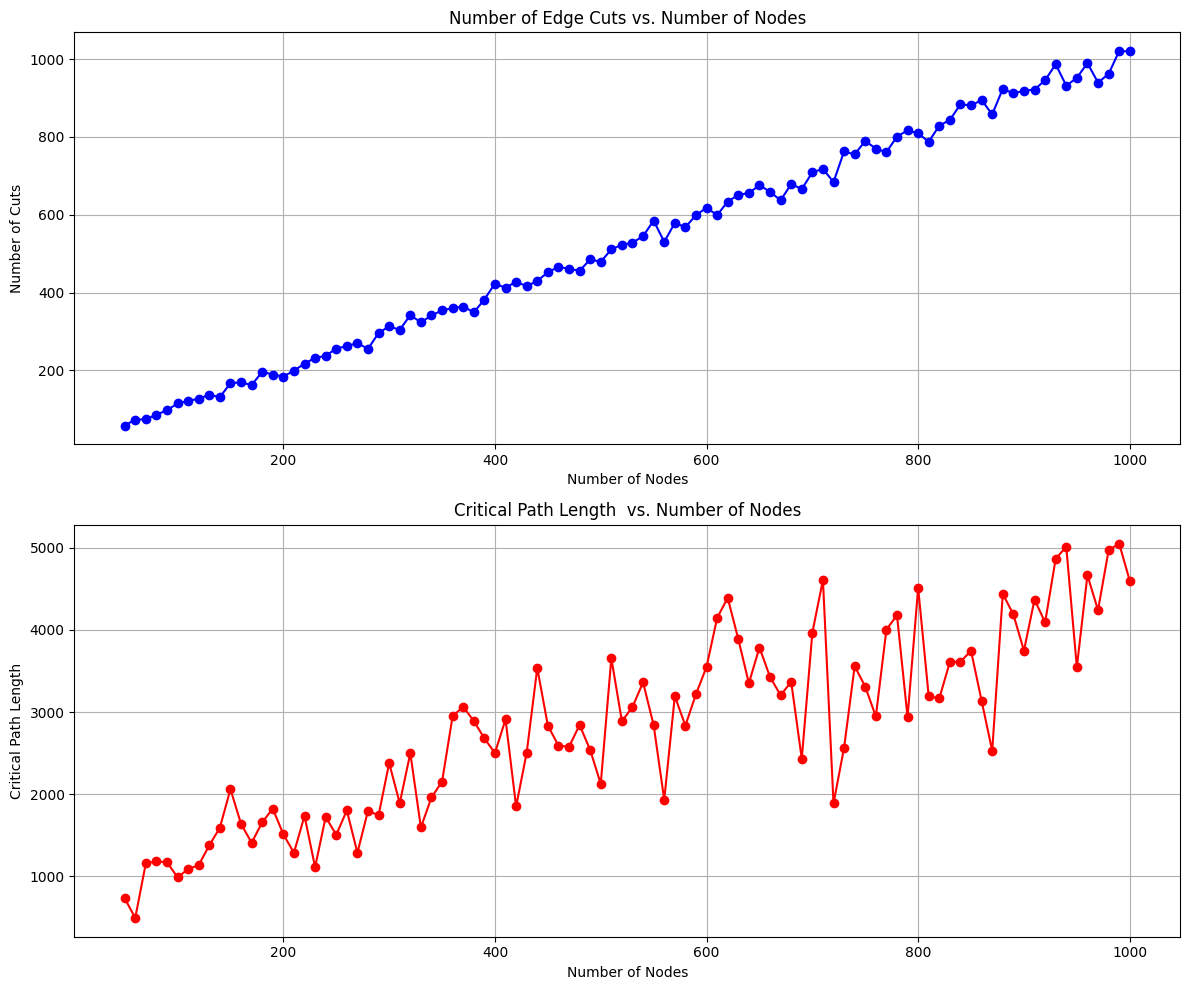


Numerical Results:
Nodes:  50, Cuts:  58.00, Wire Length:  3291.57, Critical Length:   734.02
Nodes:  60, Cuts:  73.00, Wire Length:  4519.01, Critical Length:   493.26
Nodes:  70, Cuts:  74.00, Wire Length:  4682.48, Critical Length:  1158.48
Nodes:  80, Cuts:  86.00, Wire Length:  5437.05, Critical Length:  1182.42
Nodes:  90, Cuts:  97.00, Wire Length:  5957.82, Critical Length:  1171.80
Nodes: 100, Cuts: 115.00, Wire Length:  6655.65, Critical Length:   988.96
Nodes: 110, Cuts: 121.00, Wire Length:  6864.64, Critical Length:  1087.58
Nodes: 120, Cuts: 127.00, Wire Length:  7150.69, Critical Length:  1137.47
Nodes: 130, Cuts: 137.00, Wire Length:  8889.10, Critical Length:  1377.25
Nodes: 140, Cuts: 131.00, Wire Length:  7683.79, Critical Length:  1592.94
Nodes: 150, Cuts: 167.00, Wire Length:  9800.90, Critical Length:  2061.21
Nodes: 160, Cuts: 169.00, Wire Length: 10236.62, Critical Length:  1638.30
Nodes: 170, Cuts: 162.00, Wire Length: 10295.82, Critical Length:  1408.83
Nodes

In [16]:
# Example run
if __name__ == "__main__":
    min_nodes = 50
    max_nodes = 1000
    step = 10
    num_runs = 1

    print(f"Running scaling analysis from {min_nodes} to {max_nodes} nodes...")
    node_counts, avg_cuts, avg_wire_lengths, avg_critical_lengths = analyze_scaling(
        min_nodes, max_nodes, step, num_runs
    )

    print("Analysis complete, generating plots...")
    plot_scaling_results(node_counts, avg_cuts, avg_wire_lengths, avg_critical_lengths)

    # Print some numerical results
    print("\nNumerical Results:")
    for i, nodes in enumerate(node_counts):
        if avg_cuts[i] is not None:
            print(f"Nodes: {nodes:3d}, Cuts: {avg_cuts[i]:6.2f}, Wire Length: {avg_wire_lengths[i]:8.2f}, Critical Length: {avg_critical_lengths[i]:8.2f}")